# Data science projects for business - Final Assignment

* Filesi Gianluca 102299
* O' Donovan Luke 102312

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle

In [95]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [96]:
df_train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [97]:
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Non-Numerical Columns:", non_numerical_columns)


Numerical Columns: ['ID', 'Price', 'Prod. year', 'Cylinders', 'Airbags']
Non-Numerical Columns: ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


## Data visualization

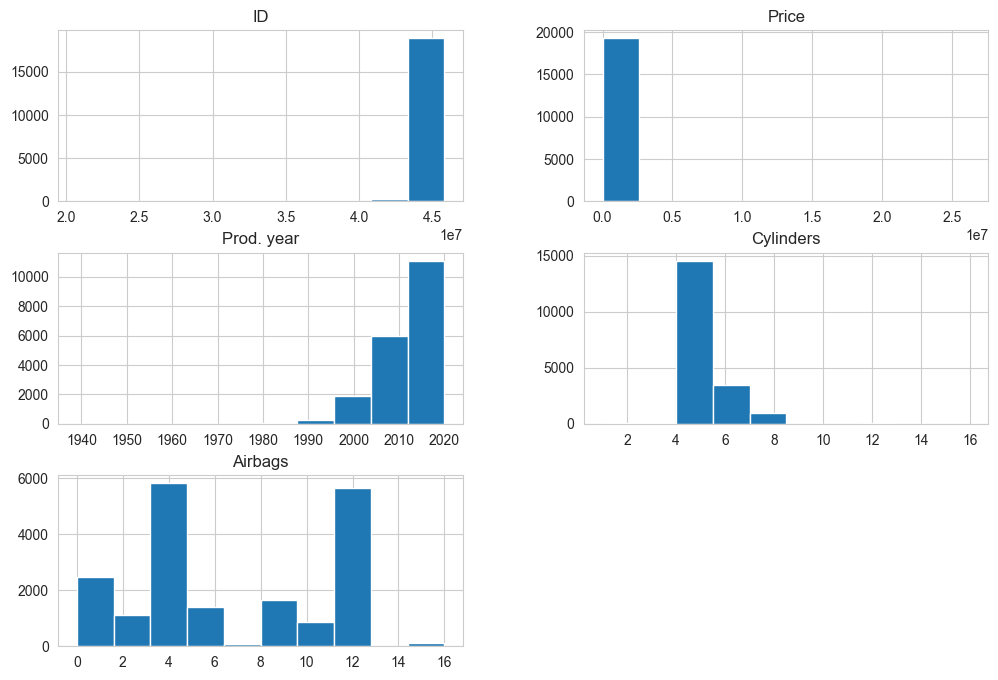

In [98]:
# Visualize distributions
df_train.hist(figsize=(12,8))
plt.show()

### Price vs Production Year

C:\Users\lukeo\AppData\Local\Temp\ipykernel_62480\581384933.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_train['Prod. year'], y=df_train['Price'], palette="viridis")


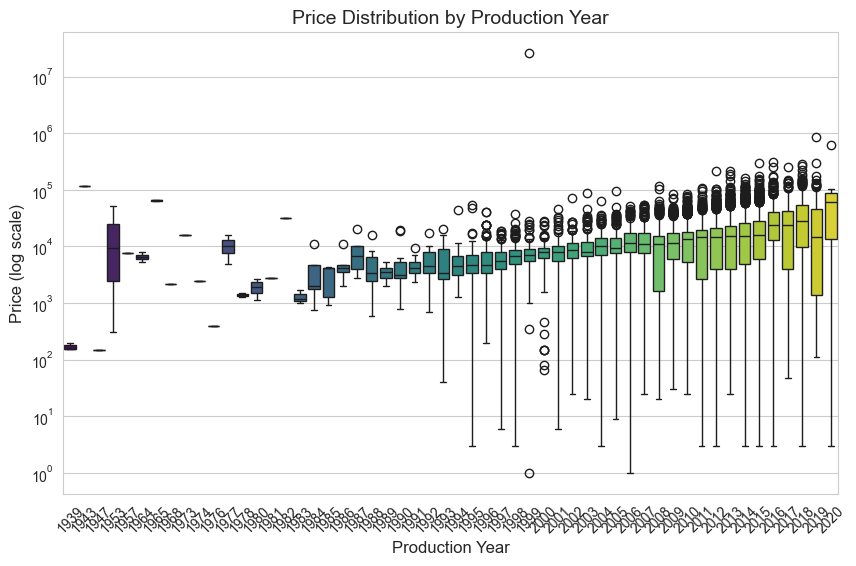

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['Prod. year'], y=df_train['Price'], palette="viridis")
plt.yscale("log")  # Log scale for price
plt.xlabel("Production Year", fontsize=12)
plt.ylabel("Price (log scale)", fontsize=12)
plt.title("Price Distribution by Production Year", fontsize=14)
plt.xticks(rotation=45)
plt.show()


### Price Distribution by Fuel Type

C:\Users\lukeo\AppData\Local\Temp\ipykernel_62480\127302286.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_train['Fuel type'], y=df_train['Price'], palette="coolwarm")


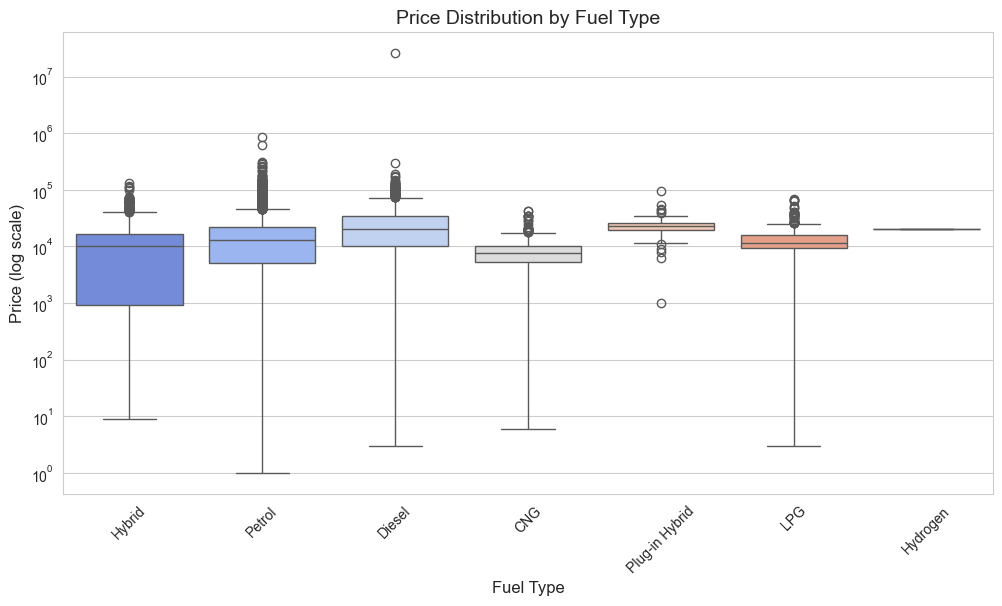

In [100]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['Fuel type'], y=df_train['Price'], palette="coolwarm")
plt.yscale("log")  # Log scale to handle price outliers
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Price (log scale)", fontsize=12)
plt.title("Price Distribution by Fuel Type", fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [101]:
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = numerical_columns[1:]

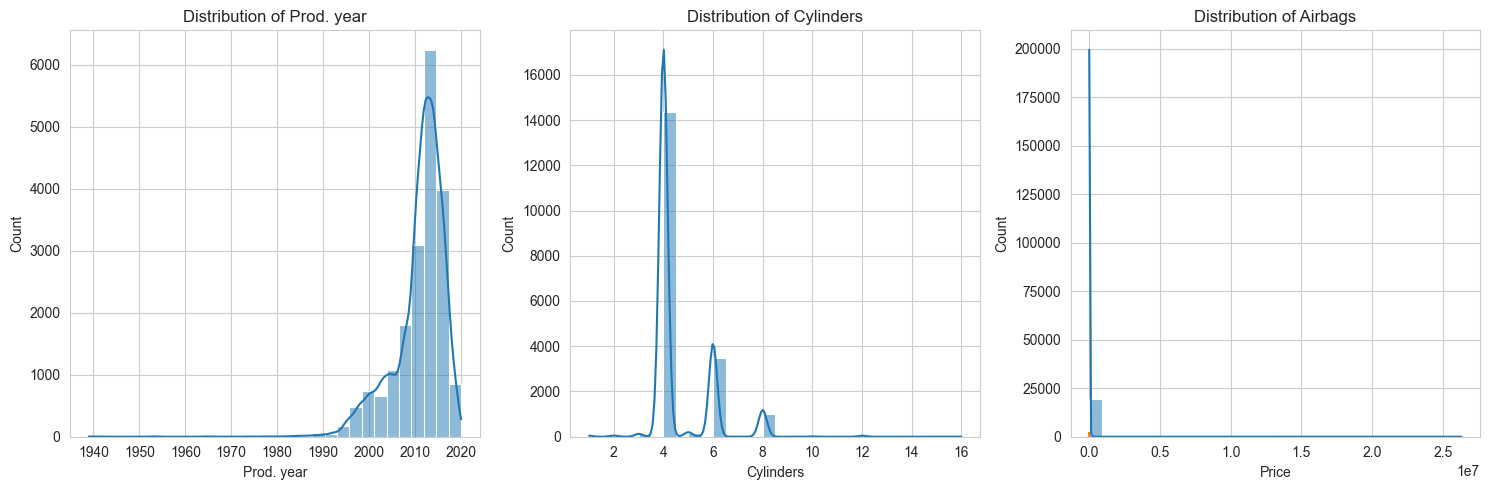

In [102]:
# Visualizing distributions of numerical features
fig, axes = plt.subplots(len(numerical_cols)//3, 3, figsize=(15, 5))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(df_train[col].dropna(), bins=30, kde=True, ax=axes[i-1])
    axes[i-1].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [103]:
# Checking skewness and kurtosis for numerical columns
print("Skewness & Kurtosis for Numerical Features:")
for col in numerical_cols:
    print(f"{col}: Skewness = {skew(df_train[col].dropna()):.2f}, Kurtosis = {kurtosis(df_train[col].dropna()):.2f}")

Skewness & Kurtosis for Numerical Features:
Price: Skewness = 136.46, Kurtosis = 18819.62
Prod. year: Skewness = -2.08, Kurtosis = 11.33
Cylinders: Skewness = 2.09, Kurtosis = 6.48
Airbags: Skewness = 0.08, Kurtosis = -1.33


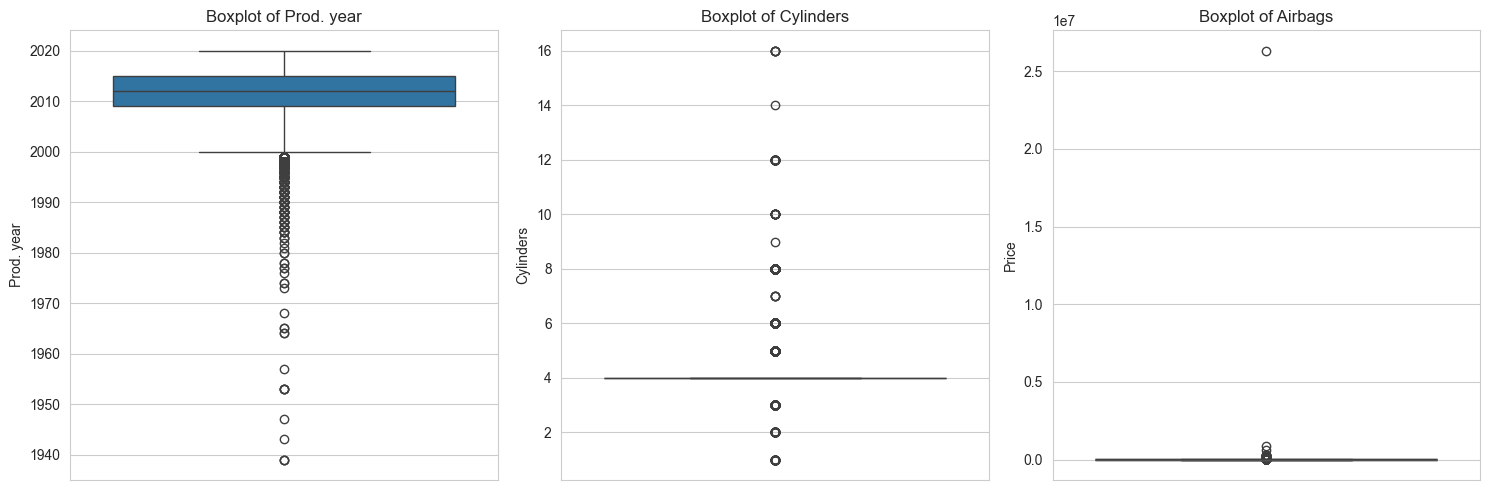

In [104]:
# Boxplots for detecting outliers
fig, axes = plt.subplots(len(numerical_cols)//3, 3, figsize=(15, 5))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_train[col], ax=axes[i-1])
    axes[i-1].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

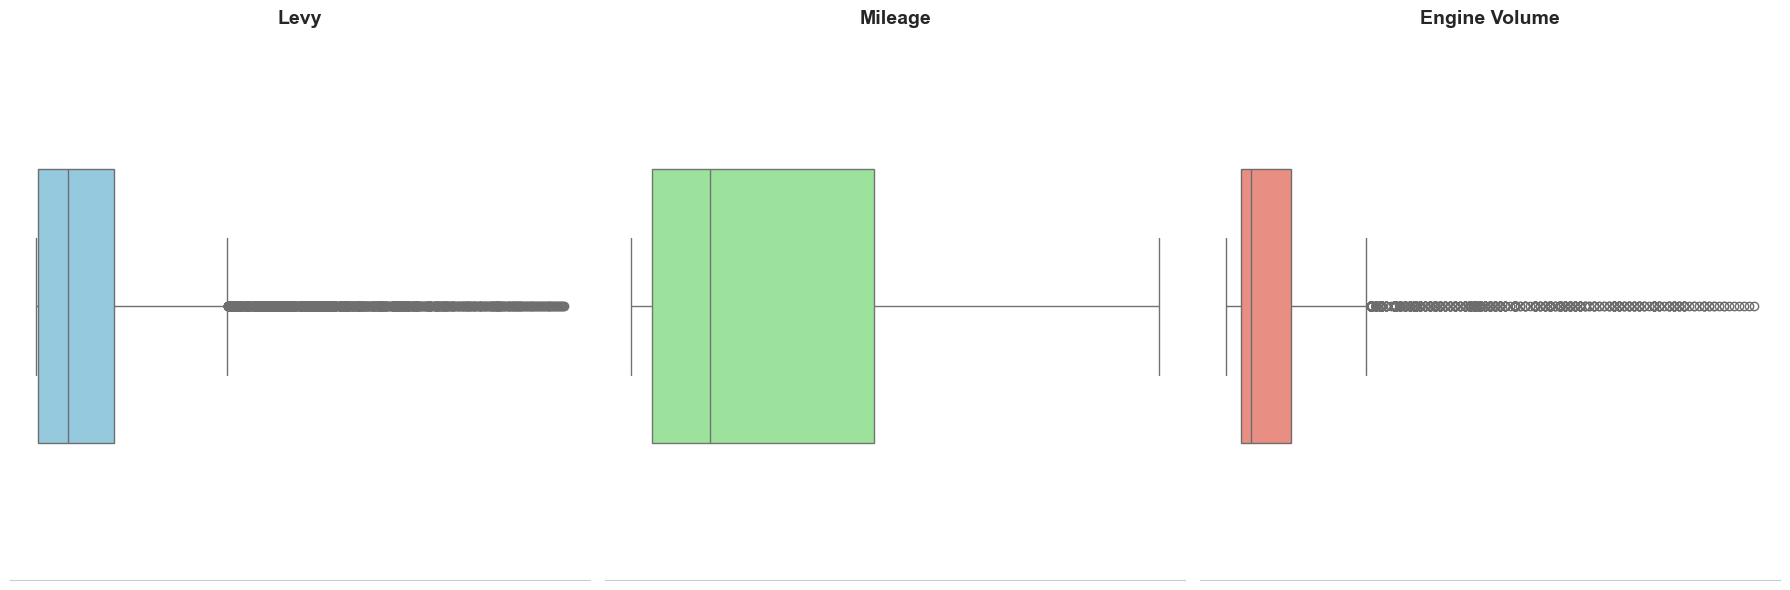

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for Levy
sns.boxplot(x=df_train['Levy'], ax=axs[0], color="skyblue", width=0.5)
axs[0].set_title("Levy", fontsize=14, fontweight='bold')
axs[0].set_ylabel("")
axs[0].set_yticklabels([])
axs[0].get_xaxis().set_visible(False)
sns.despine(ax=axs[0], left=True)

# Boxplot for Mileage
sns.boxplot(x=df_train['Mileage'], ax=axs[1], color="lightgreen", width=0.5)
axs[1].set_title("Mileage", fontsize=14, fontweight='bold')
axs[1].set_ylabel("")
axs[1].set_yticklabels([])
axs[1].get_xaxis().set_visible(False)
sns.despine(ax=axs[1], left=True)

# Boxplot for Engine Volume
sns.boxplot(x=df_train['Engine volume'], ax=axs[2], color="salmon", width=0.5)
axs[2].set_title("Engine Volume", fontsize=14, fontweight='bold')
axs[2].set_ylabel("")
axs[2].set_yticklabels([])
axs[2].get_xaxis().set_visible(False)
sns.despine(ax=axs[2], left=True)

plt.tight_layout()
plt.show()

###  Top 10 Most Frequent Car Manufacturers

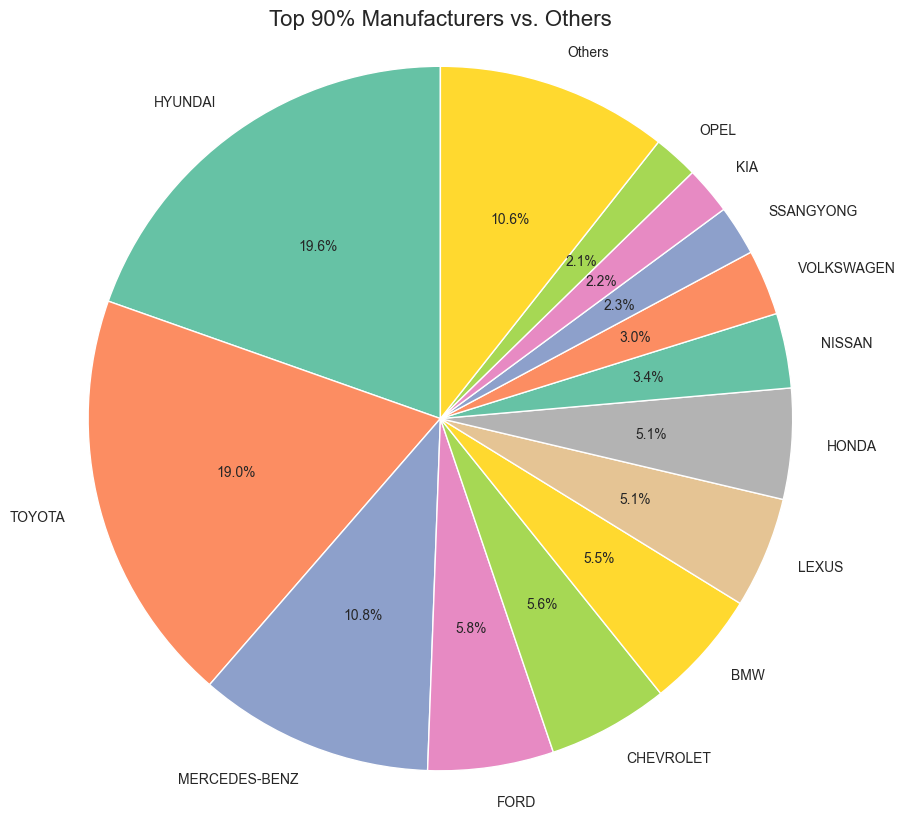

In [106]:

# Count the frequency for all manufacturers
manufacturer_counts = df_train['Manufacturer'].value_counts()


# For comparison, aggregate less frequent manufacturers into "Others"
top_13 = manufacturer_counts.head(13)
others_sum = manufacturer_counts.iloc[13:].sum()
top_13['Others'] = others_sum

colors = sns.color_palette("Set2", len(top_13))

plt.figure(figsize=(10, 10))
plt.pie(top_13, labels=top_13.index, autopct='%1.1f%%', startangle=90,
    colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title("Top 90% Manufacturers vs. Others", fontsize=16)
plt.axis('equal')
plt.show()


## Data preprocessing

- Engine volume: convert to numbers + dummy variable for turbo ones

- Levy: convert to number

- Mileage: remove km to convert them in figures

In [107]:
# EDA: Check for missing values
print(df_train.isnull().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [108]:
def converting(df):
    # Convert Levy to numeric (handling missing values)
    df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce').fillna(0)

    # Convert Mileage to numeric (removing non-numeric characters)
    df['Mileage'] = df['Mileage'].str.replace(r'\D+', '', regex=True).astype(float)

    # Create a dummy column for "turbo" (1 if "turbo" is present, else 0)
    df['turbo'] = df['Engine volume'].str.contains('turbo', case=False, na=False).astype(int)
    df['Engine volume'] = df['Engine volume'].str.extract(r'(\d+)').astype(int)
    return df

df_train = converting(df_train)
df_test = converting(df_test)

### Encoding

In [109]:
OHE_cols = ['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Color'] 
Binary_cols = ['Leather interior', 'Wheel']
Num_cols = [x for x in df_train.columns if x not in OHE_cols + Binary_cols]

In [110]:
print(Num_cols)

['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'turbo']


In [111]:
Num_cols.remove('Model')
Num_cols.remove('Manufacturer')
Num_cols.remove('turbo')
Num_cols.remove('ID')

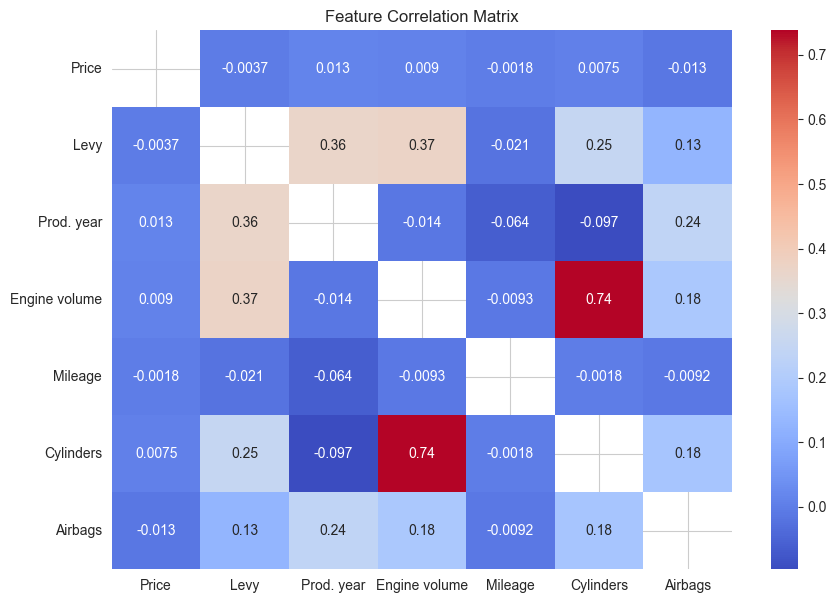

In [112]:
# Compute correlation matrix
correlation_matrix = df_train[Num_cols].corr()
np.fill_diagonal(correlation_matrix.values, np.nan)

# Visualize with heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Detecting Outliers

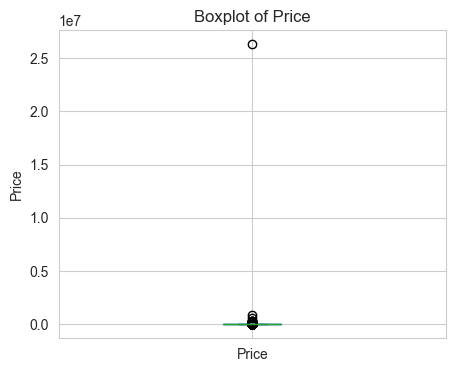

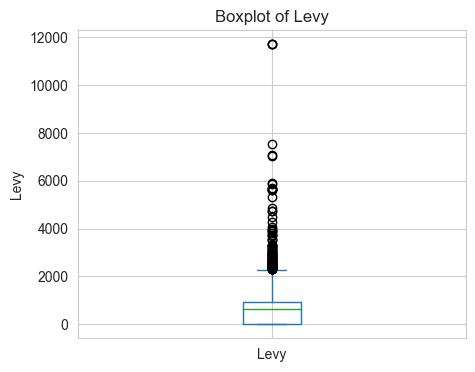

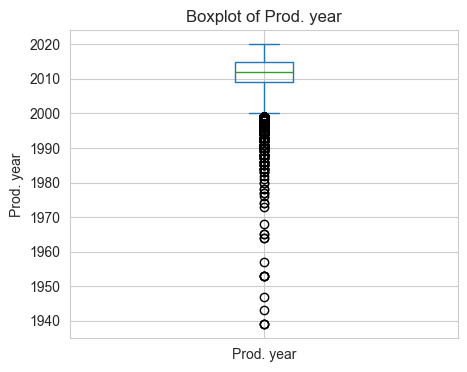

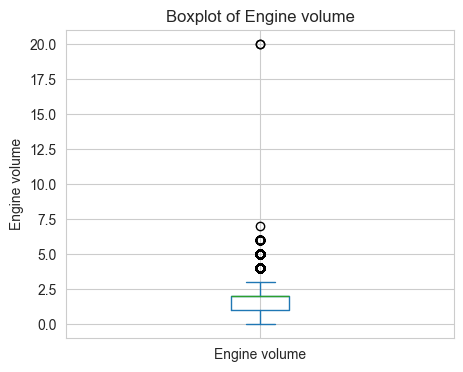

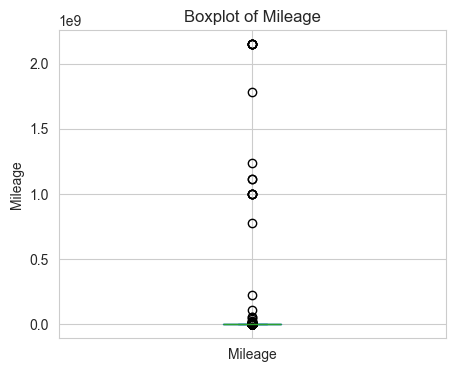

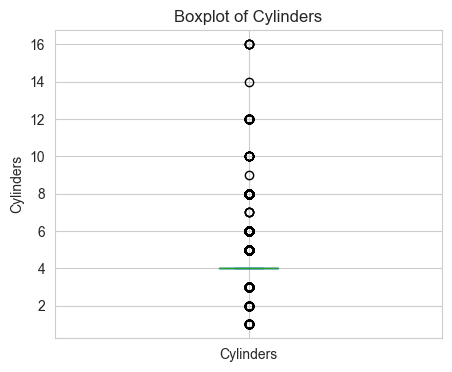

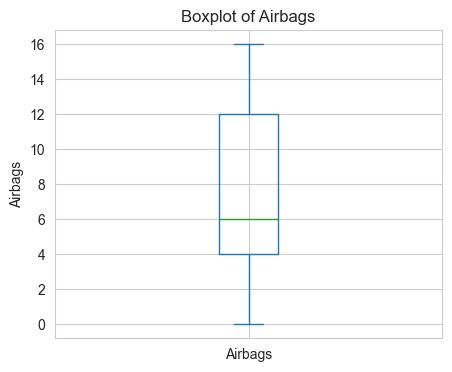

In [113]:
# Visualize outliers
for col in Num_cols:
    plt.figure(figsize=(5, 4))  
    df_train[col].plot(kind='box', vert=True, title=f"Boxplot of {col}")  
    plt.ylabel(col)
    plt.show()

In [114]:
features = ['Levy', 'Price', 'Engine volume', 'Mileage']

for feature in features:
    top_10 = df_train[feature].nlargest(10)  # Get top 10 largest values
    print(f"Top 10 Maximum {feature}:\n{top_10}\n")


Top 10 Maximum Levy:
115      11714.0
18984    11714.0
18957    11706.0
17117     7536.0
3994      7063.0
2159      7058.0
5529      5908.0
5367      5877.0
17767     5681.0
2323      5679.0
Name: Levy, dtype: float64

Top 10 Maximum Price:
16983    26307500
8541       872946
1225       627220
5008       308906
9367       297930
14839      297930
7749       288521
10759      260296
5840       254024
15283      250574
Name: Price, dtype: int64

Top 10 Maximum Engine volume:
2357     20
17777    20
5367      7
1086      6
1125      6
1225      6
1314      6
1349      6
2051      6
2125      6
Name: Engine volume, dtype: int64

Top 10 Maximum Mileage:
2278     2.147484e+09
6157     2.147484e+09
11901    2.147484e+09
12734    2.147484e+09
15347    2.147484e+09
15393    2.147484e+09
19167    2.147484e+09
17582    1.777778e+09
7724     1.234568e+09
9524     1.111111e+09
Name: Mileage, dtype: float64



In [115]:
df_cleaned = df_train.copy()

In [116]:
Q1 = df_train['Mileage'].quantile(0.10)  # First quartile (15th percentile)
Q3 = df_train['Mileage'].quantile(0.90)  # Third quartile (85th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define bounds
lower_bound = Q1 - 1.8 * IQR
upper_bound = Q3 + 1.8 * IQR

# Remove outliers
df_cleaned = df_cleaned[df_cleaned['Mileage'] <= upper_bound]

### Remove top value of Levy , Price and engine volume 

In [117]:
# Identify the max values for each feature
max_price = df_train['Price'].max()
max_engine_volume = df_train['Engine volume'].max()

# Remove rows where:
# - Levy is greater than 11,000
# - Price is the maximum value
# - Engine volume is the maximum value
df_cleaned = df_cleaned[
    (df_cleaned['Levy'] <= 11000) &  # Remove rows where Levy > 11,000
    (df_cleaned['Price'] != max_price) & 
    (df_cleaned['Engine volume'] != max_engine_volume)
]


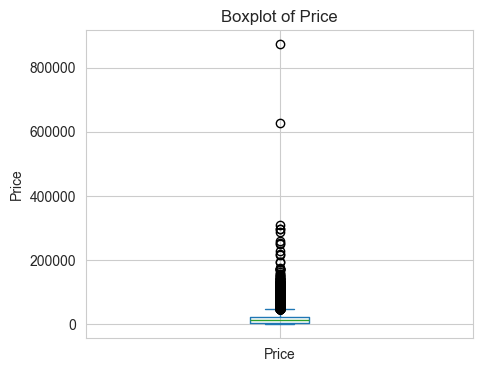

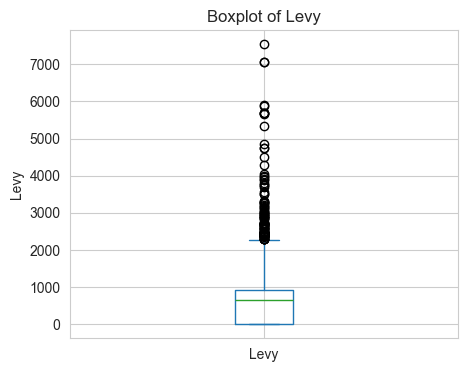

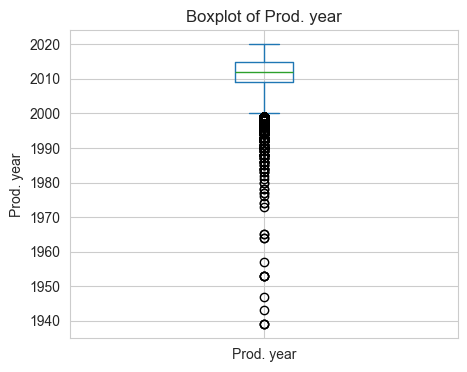

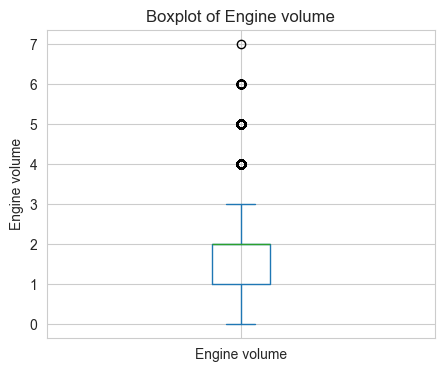

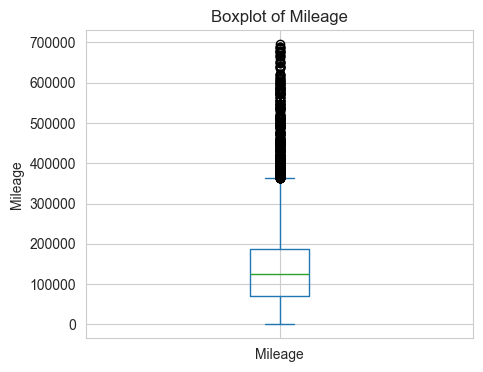

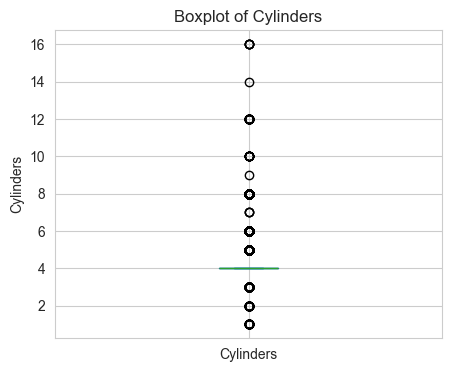

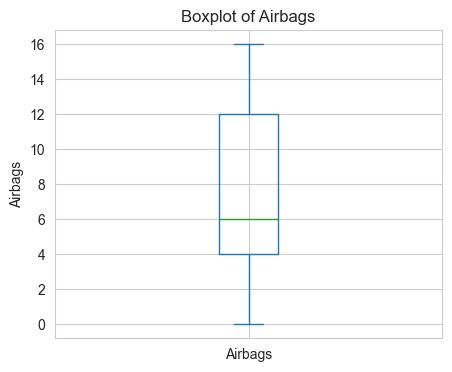

In [118]:
# Visualize outliers
for col in Num_cols:
    plt.figure(figsize=(5, 4))  
    df_cleaned[col].plot(kind='box', vert=True, title=f"Boxplot of {col}")  
    plt.ylabel(col)
    plt.show()

In [119]:
df_train_OLD = df_train
df_train = df_cleaned

## Categorical to Dummies

In [120]:
def enc(df):
    encoder = OneHotEncoder(sparse_output=False) 

    # Fit and transform the selected columns
    encoded_array = encoder.fit_transform(df[OHE_cols])

    # Convert to DataFrame and retain column names
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(OHE_cols))

    # Drop original categorical columns and concatenate the new encoded columns
    df = df.drop(OHE_cols, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

    encoder = OneHotEncoder(sparse_output=False,drop='if_binary')

    # Fit and transform the selected columns
    encoded_array = encoder.fit_transform(df[Binary_cols])

    # Convert to DataFrame and retain column names
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(Binary_cols))

    # Drop original categorical columns and concatenate the new encoded columns
    df = df.drop(Binary_cols, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

    return df

In [ ]:
def Manu(df,percentage):
    manufacturer_percentage = df['Manufacturer'].value_counts(normalize=True).mul(100).round(2)

    # First, sort the manufacturer percentages in descending order
    sorted_manufacturers = manufacturer_percentage.sort_values(ascending=False)

    # Compute cumulative sum of these percentages
    cumulative = sorted_manufacturers.cumsum()

    # Select manufacturers that together account for up to 90% of the data
    manufacturers_90 = sorted_manufacturers[cumulative <= percentage]

    manufacturers = pd.concat([manufacturers_90, pd.Series({'Other': 100-manufacturers_90.sum()})], axis=0)

    # Replace manufacturers not in the top 90% with 'Other'
    df['Manufacturer'] = df['Manufacturer'].apply(lambda x: x if x in manufacturers_90.index else 'Other')

    # Create dummy variables (1 for presence, 0 for absence)
    manufacturer_dummies = pd.get_dummies(df['Manufacturer'], prefix='Manufacturer').astype(int)

    # Concatenate the dummy variables with the original dataset
    df = pd.concat([df, manufacturer_dummies], axis=1)

    # Drop the original 'Manufacturer' column 
    df.drop(columns=['Manufacturer'], inplace=True)

    return df

## Manufacteur % - Top 13 account for 90%

In [122]:
df_train = enc(df_train)
df_train = Manu(df_train,90)

df_test = enc(df_test)
df_test = Manu(df_test,90)

## Converted top 90% of manumanufacturers to dummy variables 

In [123]:
df_train.head()

,ID,Price,Levy,Model,Prod. year,Engine volume,Mileage,Cylinders,Airbags,turbo,...,Manufacturer_HYUNDAI,Manufacturer_KIA,Manufacturer_LEXUS,Manufacturer_MERCEDES-BENZ,Manufacturer_NISSAN,Manufacturer_OPEL,Manufacturer_Other,Manufacturer_SSANGYONG,Manufacturer_TOYOTA,Manufacturer_VOLKSWAGEN
0,45654403,13328,1399.0,RX 450,2010,3,186005.0,6.0,12,0,...,0,0,1,0,0,0,0,0,0,0
1,44731507,16621,1018.0,Equinox,2011,3,192000.0,6.0,8,0,...,0,0,0,0,0,0,0,0,0,0
2,45774419,8467,0.0,FIT,2006,1,200000.0,4.0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,45769185,3607,862.0,Escape,2011,2,168966.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,45809263,11726,446.0,FIT,2014,1,91901.0,4.0,4,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
df_test.head()

,ID,Levy,Model,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Price,turbo,...,Manufacturer_HYUNDAI,Manufacturer_KIA,Manufacturer_LEXUS,Manufacturer_MERCEDES-BENZ,Manufacturer_NISSAN,Manufacturer_OPEL,Manufacturer_Other,Manufacturer_SSANGYONG,Manufacturer_TOYOTA,Manufacturer_VOLKSWAGEN
0,44020629,0.0,Golf,2012,2,0.0,4,10,NaN,1,...,0,0,0,0,0,0,0,0,0,1
1,45784798,0.0,Sonata,2012,2,26000.0,4,10,NaN,0,...,1,0,0,0,0,0,0,0,0,0
2,45800257,0.0,Tiida,2005,1,168000.0,4,8,NaN,0,...,0,0,0,0,1,0,0,0,0,0
3,45797981,975.0,XC90,2012,3,143000.0,6,12,NaN,0,...,0,0,0,0,0,0,1,0,0,0
4,45814303,0.0,Astra,1993,1,200000.0,4,0,NaN,0,...,0,0,0,0,0,1,0,0,0,0


## Drop model column as there is too many unique models to account for 

In [125]:
df_train = df_train.drop(columns=['Model'])
df_train = df_train.drop(columns=['ID'])

df_test = df_test.drop(columns=['Model'])
df_test = df_test.drop(columns=['ID'])

In [126]:
df_train.head()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,turbo,Category_Cabriolet,Category_Coupe,...,Manufacturer_HYUNDAI,Manufacturer_KIA,Manufacturer_LEXUS,Manufacturer_MERCEDES-BENZ,Manufacturer_NISSAN,Manufacturer_OPEL,Manufacturer_Other,Manufacturer_SSANGYONG,Manufacturer_TOYOTA,Manufacturer_VOLKSWAGEN
0,13328,1399.0,2010,3,186005.0,6.0,12,0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,16621,1018.0,2011,3,192000.0,6.0,8,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,8467,0.0,2006,1,200000.0,4.0,2,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3607,862.0,2011,2,168966.0,4.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,11726,446.0,2014,1,91901.0,4.0,4,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Baseline Model 

In [127]:
df_draft = df_train[['Mileage', 'Price']]
df_draft = df_draft.sort_values(by='Mileage', ascending=True)

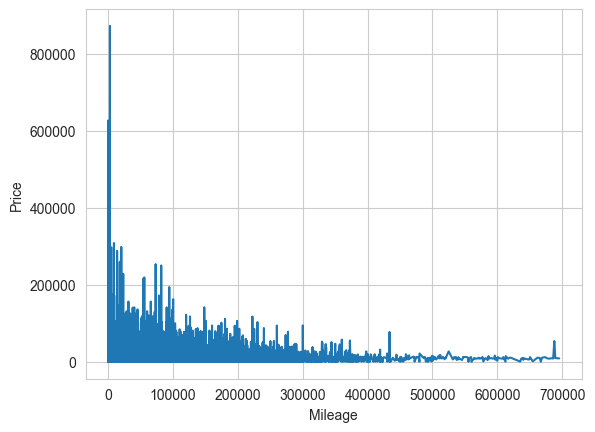

In [128]:
plt.plot(df_draft['Mileage'], df_draft['Price'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

In [ ]:
# Define features (X) and target (y)
log_mil = np.log(df_train['Mileage']+1)
X = df_train.drop(columns=["Price"])
X["Mileage"] = log_mil
y = df_train["Price"]

# Split data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 247522757.93298236
R² Score: 0.2857355392099511


# Experiment with different ML models and compare 

In [130]:
# Define features (X) and target (y)
log_mil = np.log(df_train['Mileage']+1)
X = df_train.drop(columns=["Price"])
X["Mileage"] = log_mil
y = df_train["Price"]

# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, max_depth=5),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, random_state=42, max_depth=5),
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)  

    
    # Store results
    results.append({"Model": name, "MSE": mse, "R² Score": r2, "RMSE": rmse})

# Convert results to DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)


               Model           MSE  R² Score          RMSE
0  Linear Regression  2.475228e+08  0.285736  15732.856001
1   Ridge Regression  2.473636e+08  0.286195  15727.798005
2      Decision Tree  2.178121e+08  0.371470  14758.457105
3      Random Forest  1.753104e+08  0.494115  13240.481959
4  Gradient Boosting  1.250399e+08  0.639178  11182.123285


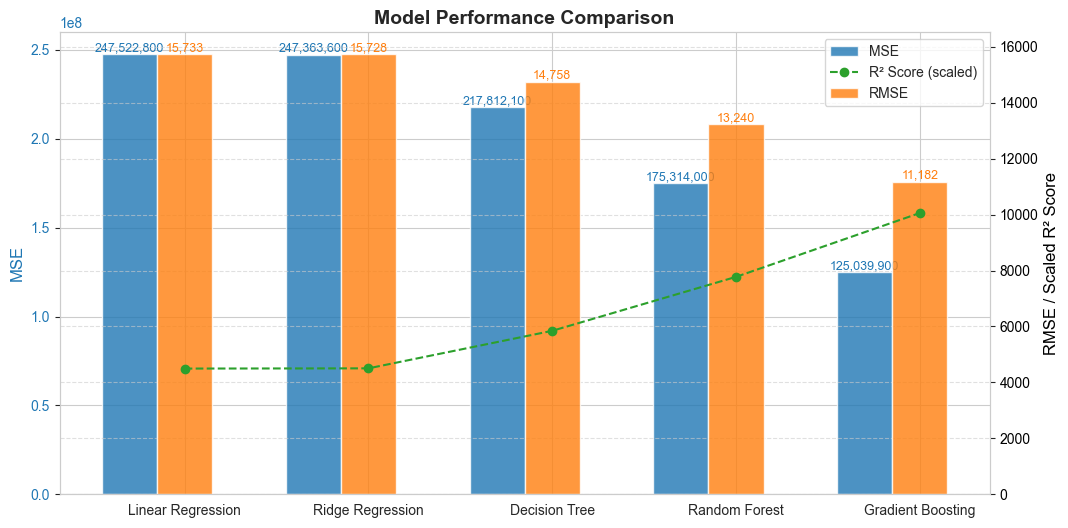

In [131]:
# Model results
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Decision Tree", "Random Forest", "Gradient Boosting"],
    "MSE": [247522800.0, 247363600.0, 217812100.0, 175314000.0, 125039900.0],
    "R² Score": [0.2857, 0.2862, 0.3715, 0.4941, 0.6392],
    "RMSE": [15732.86, 15727.80, 14758.46, 13240.48, 11182.12]
})

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.3
x = np.arange(len(results_df["Model"]))

# MSE Bars (Primary Y-Axis)
ax1.bar(x - bar_width, results_df["MSE"], bar_width, label="MSE", color="#1f77b4", alpha=0.8)
ax1.set_ylabel("MSE", color="#1f77b4", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#1f77b4")

# Create secondary Y-axis
ax2 = ax1.twinx()

# RMSE & R² Score Bars (Secondary Y-Axis)
ax2.bar(x, results_df["RMSE"], bar_width, label="RMSE", color="#ff7f0e", alpha=0.8)
ax2.plot(x, results_df["R² Score"] * max(results_df["RMSE"]), "o--", color="#2ca02c", label="R² Score (scaled)")

ax2.set_ylabel("RMSE / Scaled R² Score", color="black", fontsize=12)
ax2.tick_params(axis='y', labelcolor="black")

plt.xticks(x, results_df["Model"], rotation=30, ha="right", fontsize=11)
plt.xlabel("Models", fontsize=12)
plt.title("Model Performance Comparison", fontsize=14, fontweight="bold")

for i in range(len(x)):
    ax1.text(x[i] - bar_width, results_df["MSE"][i], f"{results_df['MSE'][i]:,.0f}", ha="center", va="bottom", fontsize=9, color="#1f77b4")
    ax2.text(x[i], results_df["RMSE"][i], f"{results_df['RMSE'][i]:,.0f}", ha="center", va="bottom", fontsize=9, color="#ff7f0e")

#  legend
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# Define features (X) and target (y)
log_mil = np.log(df_train['Mileage']+1)
X = df_train.drop(columns=["Price"])
X["Mileage"] = log_mil
y = df_train["Price"]

# Split data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

# Define parameter grid for Gradient Boosting
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

# CV folds 
cv_splits = min(3, len(y_train))

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv_splits,  
    n_jobs=-1
)

# Perform GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred_best = best_model.predict(X_test_scaled)
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)
best_rmse = best_mse ** 0.5

# Print results
print("Best Hyperparameters:", best_params)
print(f"Best Model MSE: {best_mse}")
print(f"Best Model RMSE: {best_rmse}")
print(f"Best Model R² Score: {best_r2}")


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Model MSE: 95015461.84088469
Best Model RMSE: 9747.587488239575
Best Model R² Score: 0.7258184734800346


## Hyperparmater Tuning - Grid Seach 

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Model MSE: 95015461.84088469
Best Model RMSE: 9747.587488239575
Best Model R² Score: 0.7258184734800346


C:\Users\lukeo\AppData\Local\Temp\ipykernel_62480\927342987.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx],


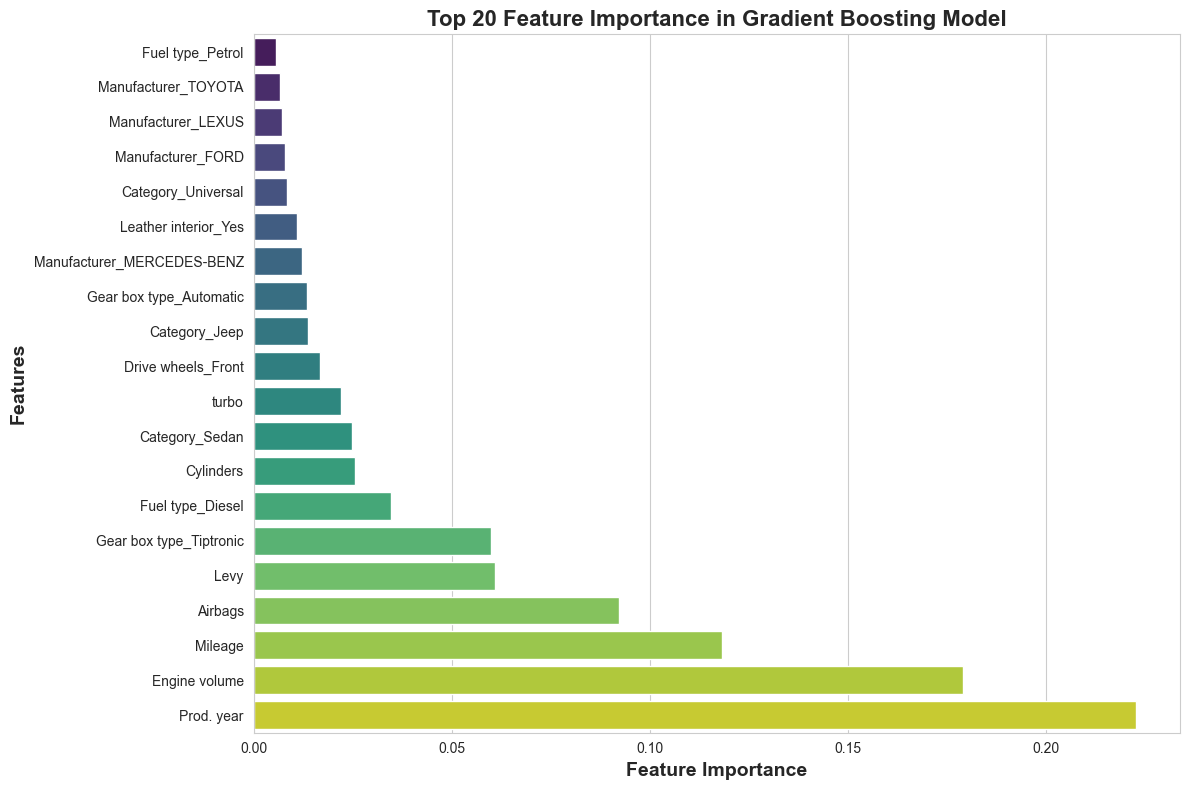

In [133]:
# Print Best Hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate Best Model on Test Data
y_pred_best = best_model.predict(X_test_scaled)
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(best_mse)

# Print Performance Metrics
print(f"Best Model MSE: {best_mse}")
print(f"Best Model RMSE: {best_rmse}")
print(f"Best Model R² Score: {best_r2}")

# Get feature importances
feature_importance = best_model.feature_importances_
features = X.columns  

# Sort Feature Importances 
sorted_idx = np.argsort(feature_importance)[-20:]  

plt.figure(figsize=(12, 8))
custom_palette = sns.color_palette("viridis", 20)
sns.barplot(x=feature_importance[sorted_idx], 
            y=[features[i] for i in sorted_idx],
            palette=custom_palette)

plt.xlabel("Feature Importance", fontsize=14, fontweight='bold')
plt.ylabel("Features", fontsize=14, fontweight='bold')
plt.title("Top 20 Feature Importance in Gradient Boosting Model", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Model Saving 

In [ ]:
model_filename = "best_gradient_boosting_model.pkl"

# Save the model using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved successfully as {model_filename}")


'# Define the filename to save the model\nmodel_filename = "best_gradient_boosting_model.pkl"\n\n# Save the model using pickle\nwith open(model_filename, \'wb\') as file:\n    pickle.dump(best_model, file)\n\nprint(f"Model saved successfully as {model_filename}")\n'